In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings 
warnings.filterwarnings('ignore')

### Time Series Modelling

Any time-series has three components - Trend, Seasonal and Residuals. Residuals are expected to be white noise, can be gaussian distributed for example. We can do time-series modelling as follows: 
1. Make different models for individual components:
    1. Trend - Curve Fitting, Rolling Average
    2. Seasonality - Sinusoidal functions 
    3. Residuals - ARIMA
2. Model (Trend + Residuals) and Seasonality separately:
    1. ARIMA for trend modelling
    2. Sinusoidal functions for seasonality
3. Model Trend + Seasonality + Residuals together:
    1. **SARIMA:** without exogenous variables
    2. **SARIMAX:** with exogeneous variables

In [2]:
periodicity = 12
significance_level = 0.05

In [3]:
df = pd.read_csv('airline-passengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
print(df.shape)
df.head()

(144, 1)


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


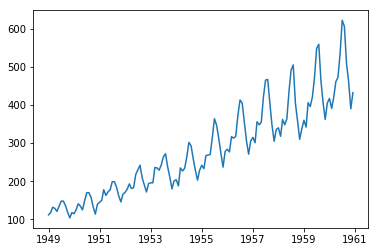

In [4]:
plt.plot(df['Passengers'])
plt.show()

### Steps:

1. Train-Validation Split
2. Seasonal decomposition to check presence of seasonality or not (additive or multiplicative model)
    1. If present: SARIMA or ARIMA + Seasonality modelling
    2. Else: ARIMA (Trend modelling)
3. Finding order of differencing d/D required for trend/seasonal modelling using ADCF test
4. Finding orders of ARIMA/SARIMA model using ACF, PACF plots:
    1. Approach 1:
        1. AR order - AR(p), number of **positive** lags crossed by significance limit in ACF plot
        2. MA order - MA(q), number of **positive** lags crossed by significance limit in PACF plot
        3. Seasonal AR order - AR(P) - number of **positive** seasonal lags crossed by significance limit in ACF plot
        4. Seasonal MA order - AR(Q) - number of **positive** seasonal lags crossed by significance limit in PACF plot
    2. Approach 2:
        1. Optimizing following criterion across range of plausible orders:
            1. In-sample criterion:
                1. AIC (Aikaike Information Criterion)
                2. BIC (Bayesian Information Criterion)
            2. Out-of-sample criterion:
                1. Appropriate metric like MAPE (Mean Absolute Percentage Error)
    3. Keep the orders conservative in order to prevent overfitting
5. Fitting the model
6. Checking for residuals after model fitting to look for underfitting/overfitting
7. Forecasting for future time steps 
8. Comparison with ground truth using metrics

In [5]:
val_pct = 0.1
val_size = int(len(df) * val_pct)

train_df = df[:-val_size]
val_df = df[-val_size:]
len(train_df), len(val_df)

(130, 14)

The amplitude of seasonal trend appears to be increasing. This suggests that we should assume a multiplicative model.

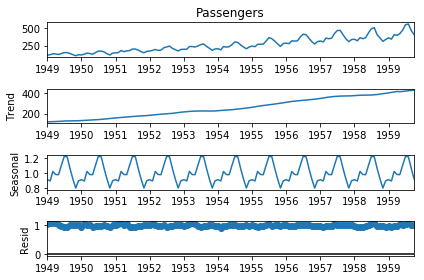

In [6]:
result = seasonal_decompose(train_df['Passengers'], model='multiplicative', period=periodicity, extrapolate_trend='freq')
result.plot()
plt.show()

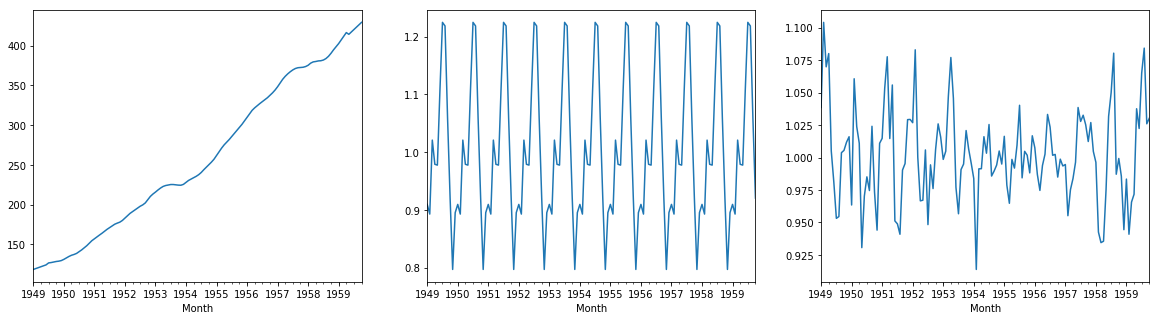

In [7]:
trend = result.trend
seasonal = result.seasonal
residuals = result.resid

plt.figure(figsize=(20, 5))
plt.subplot(131)
trend.plot()

plt.subplot(132)
seasonal.plot()

plt.subplot(133)
residuals.plot()
plt.show()

As we can notice that there is seasonality present in time series, we will look at two approaches now:
1. ARIMA + Seasonality modelling: 
    1. Fitting ARIMA on Trend and residuals jointly
    2. Adding/multiplying seasonal component to above result
2. SARIMA

We also notice that the residuals follow gaussian distribution as can be expected.

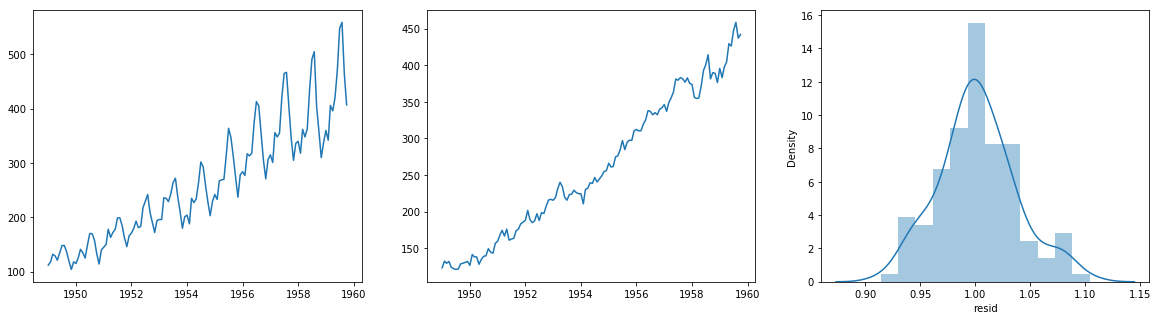

In [8]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(trend * seasonal * residuals)

plt.subplot(132)
plt.plot(trend * residuals)

plt.subplot(133)
sns.distplot(residuals)
plt.show()

### ARIMA + Seasonality modelling

In [9]:
def seasonal_val(seasonal, train_df, val_df, periodicity):
    seasonal_values = seasonal.values[:periodicity]
    start = periodicity - len(train_df) // periodicity
    n_cycles = (len(val_df) - start) // periodicity
    end = len(val_df) - start - n_cycles * periodicity

    idx = list(range(periodicity))
    idxs = idx[-start:] + n_cycles * idx + idx[:end]
    return seasonal_values[idxs]

#### ADCF (Augmented Dickey-Fuller) Test
The null hypothesis of ADCF test is that time-series is not stationary.

In [10]:
t_stat, p_value, usedlag, nobs, _, _ = adfuller(residuals, maxlag=12)
print('P-Value:', p_value)
print('Lag:', usedlag, '\n')

if p_value < significance_level:
    # null hypothesis rejected
    print('Time series is stationary')
else:
    # null hypothesis failed to reject
    print('Time Series is not stationary')

P-Value: 6.796506669916085e-10
Lag: 7 

Time series is stationary


### Finding order of ARIMA (p, d, q)

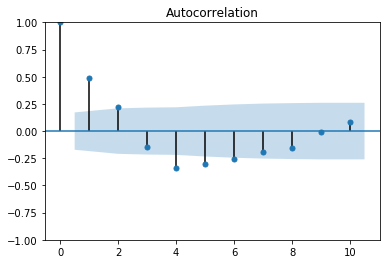

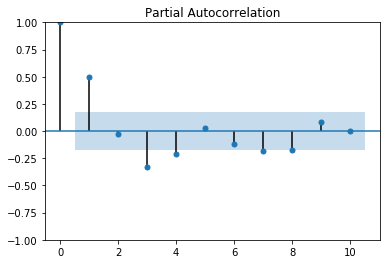

In [11]:
plot_acf(residuals, alpha=significance_level, lags=10)
plot_pacf(residuals, alpha=significance_level, lags=10)
plt.show()

### Testing ARIMA models for different orders

We will check different combinations of p, q i.e. orders of AR and MA in ARIMA(p, d, q), where we know d = 0 as there is no differencing required to make time series stationary. 

We will optimize the followiing criterion: 
1. In-sample criterion: AIC, BIC 
    1. AIC and BIC are relative criterion and should be compared with other models and not in absolute sense. 
    2. Lower AIC, BIC values are better.
2. Out-of-sample criterion: MAPE

In [12]:
num_forcasts = len(val_df)
y_val = val_df['Passengers'].values

orders = [(1,0,1), (1,0,2), (2,0,1), (2,0,2)]

for order in orders:
    model = ARIMA(trend * residuals, order=order)
    model_fit = model.fit()
    trend_resid_pred = model_fit.forecast(num_forcasts, alpha=0.05)
    seasonal_pred = seasonal_val(seasonal, train_df, val_df, periodicity)

    y_pred = trend_resid_pred * seasonal_pred
    mape = mean_absolute_percentage_error(y_val, y_pred)
    mape = (mape*100).round(2)
    print('Order', order, '| AIC:', int(model_fit.aic), '| BIC:', int(model_fit.bic), '| MAPE:', f'{mape}%')

Order (1, 0, 1) | AIC: 960 | BIC: 971 | MAPE: 7.67%
Order (1, 0, 2) | AIC: 955 | BIC: 969 | MAPE: 9.29%
Order (2, 0, 1) | AIC: 963 | BIC: 977 | MAPE: 7.76%
Order (2, 0, 2) | AIC: 956 | BIC: 974 | MAPE: 9.27%


Order (1, 0, 1) is appropriate which can also be inferred using ACF, PACF plots.

In [13]:
model = ARIMA(trend * residuals, order=(1,0,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  130
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -476.211
Date:                Fri, 01 Apr 2022   AIC                            960.422
Time:                        15:46:37   BIC                            971.893
Sample:                    01-01-1949   HQIC                           965.083
                         - 10-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        259.4943    185.369      1.400      0.162    -103.822     622.811
ar.L1          0.9985      0.008    124.046      0.000       0.983       1.014
ma.L1         -0.0860      0.092     -0.935      0.350      -0.266       0.094
sigma2        85.2254      9.408      9.059      0.000      66.786     103.665
===================================================================================
Ljung-Box (L1) (Q):                   1.64   Jarque-Bera (JB):                11.71
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
trend_resid_pred = model_fit.forecast(num_forcasts, alpha=0.05)
seasonal_pred = seasonal_val(seasonal, train_df, val_df, periodicity)
y_pred = trend_resid_pred * seasonal_pred
val_df['predictions'] = y_pred

mape = mean_absolute_percentage_error(y_val, y_pred)
mape = (mape*100).round(2)
print('MAPE:', f'{mape}%')

MAPE: 7.67%


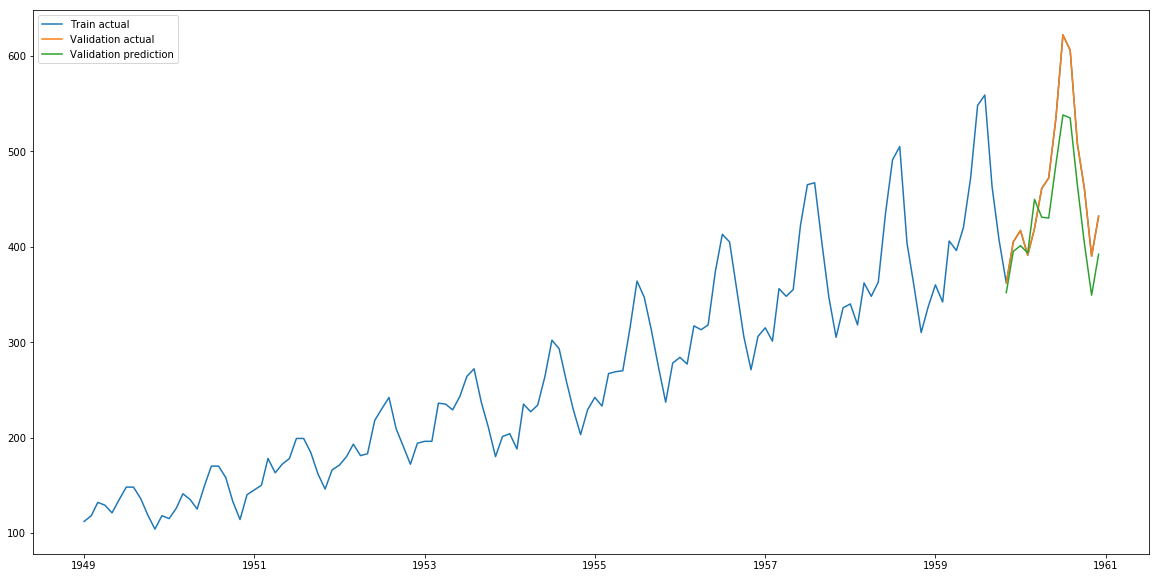

In [15]:
plt.figure(figsize=(20,10))
plt.plot(df['Passengers'], label = 'Train actual')
plt.plot(val_df['Passengers'], label = 'Validation actual')
plt.plot(val_df['predictions'], label = 'Validation prediction')
plt.legend()
plt.show()

### SARIMA: Seasonal ARIMA
#### Order - (p, d, q) X (P, D, Q)[m]

In [16]:
t_stat, p_value, usedlag, nobs, _, _ = adfuller(seasonal, maxlag=12)
print('P-Value:', p_value)
print('Lag:', usedlag, '\n')

if p_value < significance_level:
    # null hypothesis rejected
    print('Time series is stationary')
else:
    # null hypothesis failed to reject
    print('Time Series is not stationary')

P-Value: 0.0
Lag: 11 

Time series is stationary


This means that there is no differencing required for seasonal component to make it stationary, hence, D = 0.

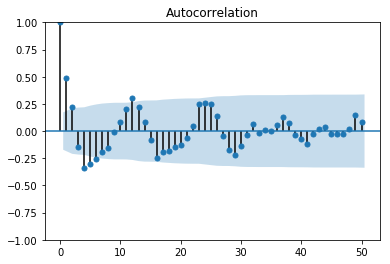

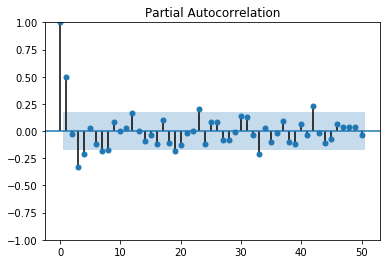

In [17]:
plot_acf(residuals, alpha=significance_level, lags=50)
plot_pacf(residuals, alpha=significance_level, lags=50)
plt.show()

From the plots, we can notice that the possible values for P and Q in **SARIMA(p,d,q)(P,D,Q)[m]** are:
1. P - 1/2
2. Q - 1

In [18]:
s = 12
orders = [(1,0,1), (1,0,2), (2,0,1), (2,0,2)]
seasonal_orders = [(1,0,1,s), (1,0,2,s), (2,0,1,s), (2,0,2,s)]

for order in orders:
    for seasonal_order in seasonal_orders:
        model = SARIMAX(train_df['Passengers'].values, order=order, seasonal_order = seasonal_order, initialization='approximate_diffuse')
        model_fit = model.fit(disp=0)

        y_pred = model_fit.forecast(num_forcasts, alpha=0.05)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        mape = (mape*100).round(2)

        print('Order', order, '| Seasonal Order', seasonal_order, '| AIC:', \
            int(model_fit.aic), '| BIC:', int(model_fit.bic), f'| MAPE: {mape}%')

Order (1, 0, 1) | Seasonal Order (1, 0, 1, 12) | AIC: 1102 | BIC: 1116 | MAPE: 3.18%
Order (1, 0, 1) | Seasonal Order (1, 0, 2, 12) | AIC: 1206 | BIC: 1223 | MAPE: 3.88%
Order (1, 0, 1) | Seasonal Order (2, 0, 1, 12) | AIC: 1197 | BIC: 1214 | MAPE: 3.2%
Order (1, 0, 1) | Seasonal Order (2, 0, 2, 12) | AIC: 1208 | BIC: 1228 | MAPE: 3.22%
Order (1, 0, 2) | Seasonal Order (1, 0, 1, 12) | AIC: 1112 | BIC: 1129 | MAPE: 3.66%
Order (1, 0, 2) | Seasonal Order (1, 0, 2, 12) | AIC: 1216 | BIC: 1236 | MAPE: 4.59%
Order (1, 0, 2) | Seasonal Order (2, 0, 1, 12) | AIC: 1198 | BIC: 1218 | MAPE: 3.68%
Order (1, 0, 2) | Seasonal Order (2, 0, 2, 12) | AIC: 1215 | BIC: 1237 | MAPE: 3.69%
Order (2, 0, 1) | Seasonal Order (1, 0, 1, 12) | AIC: 1102 | BIC: 1119 | MAPE: 3.34%
Order (2, 0, 1) | Seasonal Order (1, 0, 2, 12) | AIC: 1205 | BIC: 1225 | MAPE: 3.98%
Order (2, 0, 1) | Seasonal Order (2, 0, 1, 12) | AIC: 1205 | BIC: 1225 | MAPE: 3.49%
Order (2, 0, 1) | Seasonal Order (2, 0, 2, 12) | AIC: 1207 | BIC: 

In [19]:
order = (1,0,1)
seasonal_order = (1,0,1,12) 
model = SARIMAX(train_df['Passengers'].values, order=order, seasonal_order = seasonal_order, initialization='approximate_diffuse')
model_fit = model.fit(disp=0)
y_pred = model_fit.forecast(num_forcasts, alpha=0.05)
val_df['predictions'] = y_pred

mape = mean_absolute_percentage_error(y_val, y_pred)
mape = (mape*100).round(2)
print('MAPE:', f'{mape}%')

MAPE: 3.18%


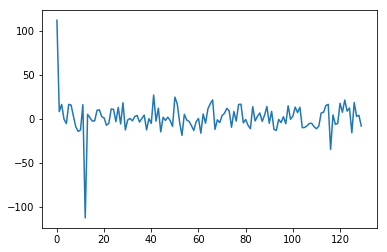

In [20]:
arima_residuals = train_df['Passengers'].values - model_fit.fittedvalues
plt.plot(arima_residuals)
plt.show()

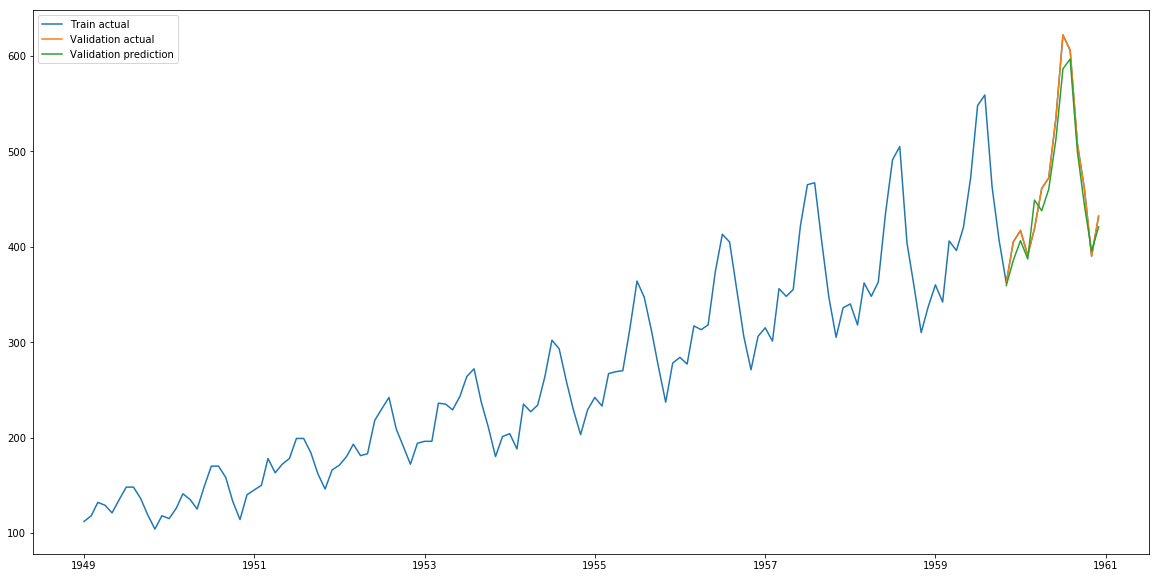

In [21]:
plt.figure(figsize=(20,10))
plt.plot(df['Passengers'], label = 'Train actual')
plt.plot(val_df['Passengers'], label = 'Validation actual')
plt.plot(val_df['predictions'], label = 'Validation prediction')
plt.legend()
plt.show()